Dataset Preview:
       price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
Categorical Columns: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'ai

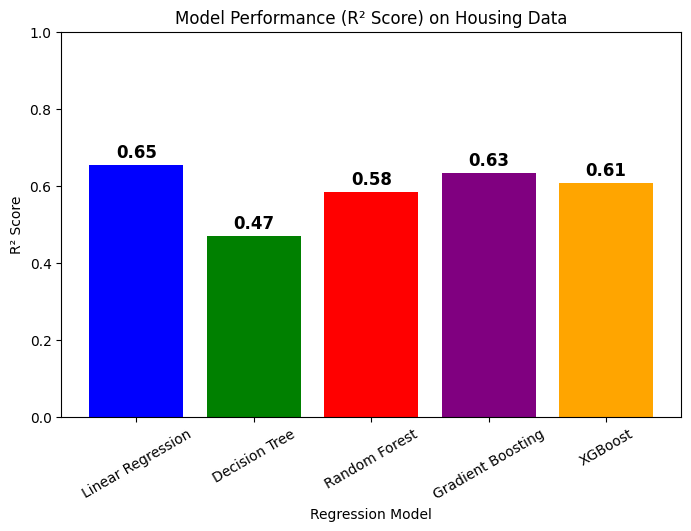

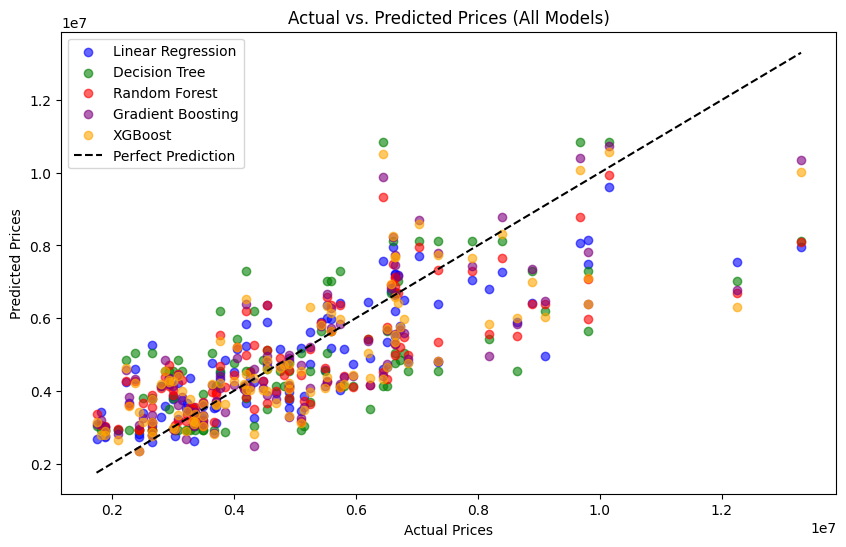

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Load dataset
df = pd.read_csv("Housing.csv")  # Make sure this path is correct

# Print dataset preview
print("Dataset Preview:\n", df.head())

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)

# Define feature preprocessing (OneHotEncoder for categorical features)
preprocessor = ColumnTransformer([
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_cols)
], remainder="passthrough")

# Separate features and target
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target (House Prices)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define regression models
models = {
    "Linear Regression": Pipeline([
        ("preprocessor", preprocessor),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "Decision Tree": Pipeline([
        ("preprocessor", preprocessor),
        ("model", DecisionTreeRegressor(max_depth=5, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocessor", preprocessor),
        ("model", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
    ])
}

# Train models and collect performance scores
r2_scores = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    r2_scores[name] = r2_score(y_test, y_pred)

# ✅ FIX: Train XGBoost separately (without pipeline)
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_enc, y_train)
y_pred_xgb = xgb_model.predict(X_test_enc)
predictions["XGBoost"] = y_pred_xgb
r2_scores["XGBoost"] = r2_score(y_test, y_pred_xgb)

# Plot 1: R² Score Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(r2_scores.keys(), r2_scores.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Regression Model")
plt.ylabel("R² Score")
plt.title("Model Performance (R² Score) on Housing Data")
plt.ylim(0, 1)
for i, v in enumerate(r2_scores.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')
plt.xticks(rotation=30)
plt.show()

# Plot 2: Scatter Plot of Actual vs. Predicted Prices for All Models
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for (name, y_pred), color in zip(predictions.items(), colors):
    plt.scatter(y_test, y_pred, alpha=0.6, label=name, color=color)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black', label="Perfect Prediction")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices (All Models)")
plt.legend()
plt.show()
